# Calculating costs for extracting relationships from the entire corpus of PubMed

There are 32 million pubmed articles. Approximately 83% of articles are in English and approximately 64% of articles have abstracts. [source](https://www.nlm.nih.gov/bsd/medline_lang_distr.html)  

Since important relationships between concepts are likely to be repeated in multiple articles over the years we can start with more recent publications. Since the year 2000 there were over 13 million articles published in English and these will form the initial basis for the knowledge graph. Of those articles approximately 12 million have abstracts. 

That give us 1 million articles with just titles and 12 million articles with titles + abstracts to process. The maximum length of abstracts from the year 2000 to 2016 was 10,000 characters, and from 2016 onward was not limited. 

Transformer models break text into tokens which consist of approximately 4 characters. That makes the maximum number of tokens for each abstract approximately 2,500 tokens. 

## Cloud GPT-J provider: ForeFront

ForeFront says they produce a 50-token output (about 200 characters) in about 1.27 seconds. If we assume our output will be 100 tokens (about 400 characters), that's conservatively 3 seconds per request. At that rate, 13 million requests would take:

In [15]:
seconds = 13000000*3
minutes = seconds/60
hours = minutes/60
days = hours/24
print(round(days), 'days')

451 days


Since ForeFront is a cloud provider, they could parallelize the process across multiple machines to reduce the total processing time. 

Fine-tuning a model with ForeFront is free, so we can practice our fine-tuning and assess performance before we invest in either our own hardware or a third party like ForeFront.

Can handle requests in parallel. 
Cost is 1.39 dollars/hour for lesser performance or 2.75 dollars/hr for TPU v2 or better performance.

Instructions on fine-tuning using ForeFront: https://docs.helloforefront.com/gpt-j/fine-tune  
Instructions on preparing a dataset for fine-tuning: https://www.helloforefront.com/blog-posts/preparing-a-dataset-to-fine-tune-gpt-j

## Fine-tuning
### Planning
Let's choose standard names for relationships. We can start with the relationships used by SemRep, which we find in the SemMedDB. These relationships are:
- PROCESS_OF         
- LOCATION_OF        
- PART_OF            
- TREATS             
- ISA                
- AFFECTS            
- USES               
- COEXISTS_WITH      
- INTERACTS_WITH     
- CAUSES             
- ASSOCIATED_WITH    
- STIMULATES         
- ADMINISTERED_TO    
- INHIBITS           
- AUGMENTS           
- compared_with      
- DIAGNOSES          
- DISRUPTS           
- PRODUCES           
- PREDISPOSES        
- MEASURES           
- METHOD_OF          
- PRECEDES           
- PREVENTS           
- NEG_PROCESS_OF     
- NEG_AFFECTS        
- OCCURS_IN          
- NEG_TREATS         
- NEG_LOCATION_OF    
- higher_than        
- NEG_INTERACTS_WITH 
- NEG_PART_OF        
- NEG_COEXISTS_WITH  
- CONVERTS_TO        
- NEG_CAUSES         
- NEG_ADMINISTERED_TO
- NEG_ASSOCIATED_WITH
- NEG_STIMULATES     
- MANIFESTATION_OF   
- COMPLICATES        
- NEG_INHIBITS        
- NEG_ISA             
- NEG_DISRUPTS        
- NEG_AUGMENTS        
- NEG_PRODUCES        
- NEG_DIAGNOSES       
- NEG_PREDISPOSES     
- lower_than          
- same_as             
- NEG_PREVENTS        
- NEG_USES            
- NEG_METHOD_OF       
- NEG_PRECEDES        
- NEG_same_as         
- NEG_OCCURS_IN       
- NEG_higher_than     
- NEG_MEASURES        
- NEG_MANIFESTATION_OF
- MEASUREMENT_OF      
- NEG_COMPLICATES     
- NEG_CONVERTS_TO     
- NEG_lower_than      
- NEG_MEASUREMENT_OF  

Next, let's decide on a format for each training example. 

From the [ForeFront docs](https://www.helloforefront.com/blog-posts/preparing-a-dataset-to-fine-tune-gpt-j), here are some best-practices: 
>- Your data must be in a single text file.  
>- You should provide at least one hundred high-quality examples, ideally vetted by a human knowledgeable in the given task.  
>- You should use some kind of separator at the end of each prompt + completion in your dataset to make it clear to the model where each training example begins and ends. A simple separator which works well in almost all cases is " ##### ".  
>- Ensure that the prompt + completion doesn't exceed 2048 tokens, including the separator.

For the job of extraction, ForeFront gives this example for fine-tuning text file format:

>\#####
>
>Text: Luke Rawlence joined Aiimi as a data scientist in June, after finishing his computer science degree at the University of Lincoln.
>
>Names: Luke Rawlence
>
>\#####
>
>Text: My name is Alan Kharwal and I'm a developer from India. Steve Jobs is my inspiration.
>
>Names: Alan Kharwal, Steve Jobs
>
>\#####

For our purposes, let's just replace the word "Names:" with "Relationships:" Here's how the first training example could look:

>\#####
>
>Text: 1. Lung cancer is the leading cause of cancer death in American men and has now surpassed breast cancer as the leading cause of cancer death among American women. 2. Heavy alcohol consumption is associated with increased cancer risks. 3. Intercourse at an early age and multiple sexual partners have been linked to an increased risk of cervical cancer. 4. The most widespread environmental carcinogen, accounting for the majority of superficial skin cancers and some types of melanoma, is ultraviolet radiation from the sun.
>
>Relationships:
>- lung cancer, CAUSES, cancer death
>- breast cancer, CAUSES, cancer death
>- heavy alcohol consumption, ASSOCIATED_WITH, increased cancer risks
>- intercourse at an early age, ASSOCIATED_WITH, increased cancer risks
>- multiple sexual partners, ASSOCIATED_WITH, increased cancer risks
>- ultraviolet radiation from the sun, IS_A, environmental carcinogen
>- ultraviolet radiation from the sun, CAUSES, superficial skin cancers
>- ultraviolet radiation from the sun, CAUSES, melanoma
>
>\#####
>
>Text: ...

Note in that example that I opted to name a relationship IS_A instead of using SemRep's convention "ISA," to make it more human-readible. I made it all uppercase to conform to Neo4j's convention for relationship names. Let's follow this pattern for the rest of the relationship names.  

ForeFront docs state: "To fine-tune a model that performs better than using a high-quality prompt with vanilla GPT-J, you should provide at least one hundred high-quality examples, ideally vetted by a human knowledgeable in the given task. From there, performance tends to linearly increase with every doubling of the number of examples." 

We'll also need a set of 15 test requests to see how the model is doing during training. These test prompts will be formatted identically to a single training example, and will end with "Relationships:" It won't need the hash tags since there are no other training examples to separate from the prompt.

After fine-tuning, we'll run 100 samples. I'll correct those samples, measure the accuracy, and add them to the next iteration's fine-tuning dataset. We'll repeat the process of running 100 new samples per iteration, measuring accuracy, and adding the human-corrected version to the dataset for fine-tuning the next iteration until we reach >99% accuracy, we see the accuracy plateau, or when it would be prohibitively expensive to continue refining the model. We will keep a model registry with a model identifier and the text used for fine-tuning the model.

When we have other users, we will add any corrections they make to the fine-tuning data, which will be used next time we fine-tune a model. Eventually this fine-tuning data will become a very valuable resource, as it can also be used on more advanced GPT models when they become available (e.g. a model with more parameters, more relevant training data, etc).

### Prepare a dataset for fine-tuning

In [757]:
import requests
from bs4 import BeautifulSoup
import json
import re
import urllib.parse
import pandas as pd
import time
from datetime import datetime
import requests

In [44]:
# Prepare a list of predicates to search
SemMedDB_predicate_list = ['PROCESS_OF', 'LOCATION_OF', 'PART_OF', 'TREATS', 'ISA', 'AFFECTS', 'USES', 'COEXISTS_WITH', 'INTERACTS_WITH', 'CAUSES', 'ASSOCIATED_WITH', 'STIMULATES', 'ADMINISTERED_TO', 'INHIBITS', 'AUGMENTS', 'compared_with', 'DIAGNOSES', 'DISRUPTS', 'PRODUCES', 'PREDISPOSES', 'MEASURES', 'METHOD_OF', 'PRECEDES', 'PREVENTS', 'NEG_PROCESS_OF', 'NEG_AFFECTS', 'OCCURS_IN', 'NEG_TREATS', 'NEG_LOCATION_OF', 'higher_than', 'NEG_INTERACTS_WITH', 'NEG_PART_OF', 'NEG_COEXISTS_WITH', 'CONVERTS_TO', 'NEG_CAUSES', 'NEG_ADMINISTERED_TO', 'NEG_ASSOCIATED_WITH', 'NEG_STIMULATES', 'MANIFESTATION_OF', 'COMPLICATES', 'NEG_INHIBITS', 'NEG_ISA', 'NEG_DISRUPTS', 'NEG_AUGMENTS', 'NEG_PRODUCES', 'NEG_DIAGNOSES', 'NEG_PREDISPOSES', 'lower_than', 'same_as', 'NEG_PREVENTS', 'NEG_USES', 'NEG_METHOD_OF', 'NEG_PRECEDES', 'NEG_same_as', 'NEG_OCCURS_IN', 'NEG_higher_than', 'NEG_MEASURES', 'NEG_MANIFESTATION_OF', 'MEASUREMENT_OF', 'NEG_COMPLICATES', 'NEG_CONVERTS_TO', 'NEG_lower_than', 'NEG_MEASUREMENT_OF']
GPT_predicate_list = []
for element in predicate_list:
    element = element.lower()
    element = element.replace('_', ' ')
    GPT_predicate_list.append(element)
GPT_predicate_list.sort()

# Remove negative relationships, which are not searchable in pubmed
front = GPT_predicate_list[:21]
back = GPT_predicate_list[-11:]
GPT_predicate_list = front+back
print(GPT_predicate_list)
print('\nThere are', len(GPT_predicate_list), "unique types of predicates")

['administered to', 'affects', 'associated with', 'augments', 'causes', 'coexists with', 'compared with', 'complicates', 'converts to', 'diagnoses', 'disrupts', 'higher than', 'inhibits', 'interacts with', 'isa', 'location of', 'lower than', 'manifestation of', 'measurement of', 'measures', 'method of', 'occurs in', 'part of', 'precedes', 'predisposes', 'prevents', 'process of', 'produces', 'same as', 'stimulates', 'treats', 'uses']

There are 32 unique types of predicates


We have 32 types of conceptual relationships, so we'll do a pubmed search on each relationship term and choose 3 articles that state the relationship. We'll copy the title of the article as the first sentence and add the abstract as the remainder of the "Text: " prompt. I'll manually write out the corresponding "Relationships:" field. We'll end up with 96 training examples that span across all of our conceptual relationships of interest.

In [166]:
# Define a function that takes a term, searches PubMed for that term, and returns a list of the 
# PMIDs of the articles found
def find_pmid_list_for(term, max_result_count=30):
    esearch_query_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&retmax={retmax}&term={term}'.format(retmax=max_result_count, term=term)
    response = requests.get(esearch_query_url)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    ids_str = soup.idlist.get_text()
    ids_str = ids_str.replace('\n',',')
    ids_str = ids_str[1:-1] 
    ids_str = ids_str.split(',')
    
    return ids_str

In [292]:
# Define a function that takes a PubMed ID, fetches the title and abstract of the article from PubMed, concatenates
# the title and abstract into one block of text, and returns the block of text
def get_title_abstract_for(pmid):
    efetch_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={pmid}&retmode=xml'.format(pmid=pmid)
    efetch_response = requests.get(efetch_url)
    efetch_content = efetch_response.content
    soup = BeautifulSoup(efetch_content, 'html.parser')
    try:
        article_title = soup.articletitle.get_text()
    except:
        article_title = 'None'
    try:
        article_abstract = soup.abstracttext.get_text()
    except AttributeError:
        article_abstract = 'None'
    text = 'Title:\n'+article_title+'\nAbstract:\n'+article_abstract
    
    return text

print(get_title_abstract_for('32865446'))

Title:
Causes.
Abstract:
None


In [168]:
data = []

for term in GPT_predicate_list:
    pmid_list = find_pmid_list_for(term)
    for pmid in pmid_list:
        text = get_title_abstract_for(pmid)
        inner_list = [term, pmid, text]
        data.append(inner_list)

df = pd.DataFrame(data, columns=['term', 'pmid', 'text'])

# inspect the dataframe
df

,term,pmid,text
0,administered to,34583441,Title:\nThe relationship between lymphedema se...
1,administered to,34583418,Title:\nManual external chest compression reve...
2,administered to,34583356,Title:\nSafety and Efficacy of Tivozanib in Fi...
3,administered to,34583332,Title:\nTriangulating Evidence to Infer Pathwa...
4,administered to,34583301,Title:\nDiagnostic criteria for blepharospasm:...
...,...,...,...
955,uses,34581203,Title:\nMinimally invasive harvesting fascia l...
956,uses,34581132,Title:\n[Content and Ecological Risks of Heavy...
957,uses,34581109,Title:\n[Characteristics of Atmospheric Partic...
958,uses,34580981,Title:\nA Versatile Compact Parahydrogen Membr...


#### Extract relationships of many types by hand
Note that this approach may not be pursued. Upon attempting it, I found that some relationships have properties that others do not, so it may be necessary to develop training data for each relationship type individually. For example, the property of relationship strength makes sense for the "associated with" relationship but not the "is a" relationship. What follows is the code I used to annotate several relationship types. I'm leaving it in so it can be repurposed.

In [243]:
df.loc[df['term'] == 'causes']

,term,pmid,text,relationships
120,causes,34583368,Title:\nMarginal Sufficient Component Cause Mo...,NaN
121,causes,34583348,Title:\nEffects of Iron Supplements on Heme Sc...,NaN
122,causes,34583336,"Title:\nKnowledge, Perceptions, and Attitudes ...",NaN
123,causes,34583273,Title:\nAmmonia exposure induced intestinal in...,NaN
124,causes,34583261,Title:\nCharacteristics of dynamic magnetic re...,NaN
125,causes,34583241,Title:\nTowards a CRISPeR understanding of hom...,NaN
126,causes,34583212,Title:\nDetermining tissue conductivity in tis...,NaN
127,causes,34583201,Title:\nEconomic relationships and health ineq...,NaN
128,causes,34583167,Title:\nGestational exposure to environmental ...,NaN
129,causes,34583158,Title:\nMechanism investigation for ultra-effi...,NaN


In [244]:
row_number = 120
print(df.iloc[row_number,].text)

Title:
Marginal Sufficient Component Cause Model: An Emerging Causal Model With Merits?
Abstract:
For decades, the sufficient cause model and the counterfactual model have shaped our understanding of causation in biomedical science, and the link between these two models has enabled us to obtain a deeper understanding of causality. Recently, a new causal model-the marginal sufficient component cause model-was proposed and applied in the context of interaction or mediation. The proponents of this model have emphasized its utility in visualizing the presence of "agonism" (a subtype of mechanistic interaction) in the counterfactual framework, claiming that the concept of agonism has not been clearly defined in causal inference and that agonistic interaction cannot be visualized by the conventional sufficient cause model. In this article, we illustrate that careful scrutiny based on the conventional sufficient cause model yields further insights into the concept of agonism in a more biologi

In [239]:
# Add a list of the relationships described in the article, the conditions under which those relationships are valid,
# and the strength of the relationship (if stated). Separate fields for each relationship with commas and separate
# relationships with new lines, as follows:
# subject, verb, object, condition(s) under which assertion is true, strength of relationship
df.at[row_number,'relationships'] = '''
exhaled NO, associated with, eosinophilic airway inflammation, in patients with asthma,,
'''
df.iloc[row_number:row_number+1]

,term,pmid,text,relationships
62,associated with,34583434,Title:\nSternal defect reconstruction using a ...,"\nsternectomy, causes, deformity of chest wall..."


In [240]:
timestamp = datetime.now().strftime("%d-%m-%Y")
filename = 'GPT_fine-tuning_dataset_v{}.csv'.format(timestamp)
df.to_csv('GPT_extraction_fine-tuning_dataset.csv', index=False)
print('Saved ',filename)

print('\n', df.iloc[row_number].relationships)
empty = df.loc[df['relationships'].isnull()]
empty.groupby('term').size()

Saved  GPT_fine-tuning_dataset_v29-09-2021.csv

 
sternectomy, causes, deformity of chest wall,,,
deformity of chest wall, disrupts, respiration, in patients with sternectomy oncological defects,,



term
administered to     27
affects             27
associated with     27
augments            30
causes              30
coexists with       30
compared with       30
complicates         30
converts to         30
diagnoses           30
disrupts            30
higher than         30
inhibits            30
interacts with      30
isa                 30
location of         30
lower than          30
manifestation of    30
measurement of      30
measures            30
method of           30
occurs in           30
part of             30
precedes            30
predisposes         30
prevents            30
process of          30
produces            30
same as             30
stimulates          30
treats              30
uses                30
dtype: int64

#### Extract only causal relationships by hand
If this works well, we can expand out to other relationship types.

In [15]:
# To get the format for search query that can be passed into a URL, 
# perform an advanced search at pubmed, then copy what follows the &term= from that search's URL

# Get a list of PMIDs
# Pass the query into the ESearch utility to get a list of PMIDs

query = '(((((((cause[Title/Abstract]) NOT (all-cause[Title/Abstract])) ) ) ) OR (resulting in[Title/Abstract])) OR (due to[Title/Abstract]))'
query = urllib.parse.quote(query, safe='') # Encode the query in URL format
ESearch_base = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&retmax=150&term='
url = ESearch_base + query
response = requests.get(url)
content = response.content
soup = BeautifulSoup(content, 'html.parser')
PMIDs_list = soup.idlist.get_text()
PMIDs_list = PMIDs_list.replace('\n',',')
PMIDs_list = PMIDs_list[1:-1] 
PMIDs_list = PMIDs_list.split(',')

# Check PMIDs_list for proper format
PMIDs_list[:5]

['34587677', '34587663', '34587657', '34587654', '34587651']

The above method returned many extraneous articles, so I used PubMed to perform a new search. You can recreate this search by going to pubmed.org and pasting this into the search box: 
>(((cause[Title/Abstract]) OR (causes[Title/Abstract])) OR (caused[Title/Abstract])) NOT (all-cause[Title/Abstract]) AND ((fha[Filter]) AND (meta-analysis[Filter] OR systematicreview[Filter]) AND (humans[Filter]))

The search returned 18,061, sorted by "Best Match." Note that I chose to display the top 200 results on the page and I saved the PMIDs from those 200 results to the following file: Documents/P2_Prototype/Pubmed_search_30Sept2021-11.32am.txt  
Let's open that file and use the PMIDs from this search for our initial fine-tuning dataset.

In [67]:
with open('Pubmed_search_30Sept2021-11.32am.txt','r') as file:
    raw_list = file.readlines()
print(raw_list[:5])
    
PMIDs_list = []
for pmid in raw_list:
    pmid = pmid[:-1]
    PMIDs_list.append(pmid)
print(PMIDs_list[:5])

['31543413\n', '26461998\n', '25103301\n', '26709689\n', '22133988\n']
['31543413', '26461998', '25103301', '26709689', '22133988']


In [296]:
# Fetch the abstract for each PMID on the list
url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={PMIDs_list}&retmode=xml&rettype=abstract'
url = url.format(PMIDs_list=PMIDs_list)
response = requests.get(url)
content = response.content
soup = BeautifulSoup(content, 'html.parser')

regex_cause = r"([^.\n]*?[^-]caus*[^.]*\.[^0-9])"
regex_due = r"([^.\n]*?[^-]due to[^.]*\.[^0-9])"
regex_result = r"([^.\n]*?[^-]result*[^.]*\.[^0-9])"

def causality_search(pmid):
    sentence_list = []
    
    article = soup.find(text=pmid)
    try:
        title = article.findNext('articletitle').get_text()
    except:
        title = ""
    try:
        abstract = article.findNext('abstracttext').get_text()
    except:
        abstract = ""
    if len(title+abstract) == 0:
        pass
    else:
        title_abstract = title.upper()+' '+abstract
        sentence_list+=re.findall(regex_cause, title_abstract)
        sentence_list+=re.findall(regex_due, title_abstract)
        sentence_list+=re.findall(regex_result, title_abstract)
    if type(sentence_list) == None:
        pass
    elif len(sentence_list) == 0:
        pass
    else:
        data = ['causes', pmid, sentence_list, title_abstract]
        return data
    
# test causality_search function
print(causality_search('26709689'))

None


In [ ]:
data = []
for pmid in PMIDs_list:
    results = causality_search(pmid)
    if results == None:
        pass
    else:
        data.append(results)
    
df = pd.DataFrame(data, columns=['term', 'pmid', 'focused_sentences', 'text'])
df.info()

In [69]:
df = df.explode('focused_sentences', ignore_index=True)
df.head()

,term,pmid,focused_sentences,text
0,causes,31543413,Lateral epicondylitis is the most common caus...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...
1,causes,31543413,This article reviews the pathophysiological f...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...
2,causes,25103301,Data for the causes of maternal deaths are ne...,GLOBAL CAUSES OF MATERNAL DEATH: A WHO SYSTEMA...
3,causes,22133988,From the most recent data the magnitude of vi...,GLOBAL ESTIMATES OF VISUAL IMPAIRMENT: 2010. F...
4,causes,29032195,Contemporary data for causes of vision impair...,GLOBAL CAUSES OF BLINDNESS AND DISTANCE VISION...


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   term               344 non-null    object
 1   pmid               344 non-null    object
 2   focused_sentences  344 non-null    object
 3   text               344 non-null    object
dtypes: object(4)
memory usage: 10.9+ KB


### Annotator Tool

In [45]:
str_to_CUI = pd.read_csv('str_to_CUI.csv', encoding='utf-8')
str_to_CUI.dropna(inplace=True)
str_to_CUI.tail()

,STR,CUI,STY
14305554,ﾜﾝﾌｶｲｶﾝ,C0877610,Sign or Symptom
14305555,ﾜﾝﾍﾝｹｲ,C0919717,Anatomical Abnormality
14305556,ﾜﾝﾍﾝｹｲNOS,C0919717,Anatomical Abnormality
14305557,ﾜﾝﾎｳｿｳｴﾝ,C0562422,Disease or Syndrome
14305558,ﾜﾝﾚｯｼｮｳ,C0432974,Injury or Poisoning


In [46]:
# Define a function that conducts a fast binary search on a sorted column of a dataframe, returning only full match results.

def binary_search(dataframe, column, target):
    range_start = 0
    range_end = len(dataframe)-1
    while range_start < range_end:
        range_middle = (range_end + range_start) // 2
        value = dataframe.iloc[range_middle][column]
        if value == target:
            return dataframe.iloc[range_middle]
        elif value < target:
            # Discard the first half of the range
            range_start = range_middle + 1
        else:
            # Discard the second half of the range
            range_end = range_middle - 1
    # At this point range_start = range_end
    value = dataframe.iloc[range_start][column]
#     return value
    if value == target:
        return dataframe.iloc[range_start]
    else:
        return 0

# Test the function
start_time = time.time()
frame = binary_search(dataframe = str_to_CUI, column = 'STR', target = '心筋梗塞')
if type(frame) == int:
    print("No match")
else:
    print(frame['CUI'])
print("Runtime:", time.time() - start_time, "seconds")

C0027051
Runtime: 0.002407073974609375 seconds


In [47]:
# Define a function which takes a string and returns a list of CUIs or the strings associated with CUIs

def text_to_CUIs(text):
    
    # Remove any non-alphanumeric characters, set the encodning to unicode, and split the text into a list of words
    text = re.sub('[\W_]+', ' ', text, flags=re.UNICODE)
    text = text.split(' ')

    # Iterate through the list of words to find the largest sets of consecutive words that match CUI-associated strings, and append these to a term list
    used = set([])
    term_list = []
    for i in reversed(range(1,6)):
        index = 0
        while index < len(text):
            if not index in used:
                term = ' '.join(text[index:(index+i)])
                frame = binary_search(dataframe = str_to_CUI, column = 'STR', target = term)
                if type(frame) == int:
                    index += 1
                else:
                    used.update(range(index, index+i))
                    term_list.append([index, term, frame['CUI']])
                    index += i
            else:
                index += 1
    
    # Append any non-matched words to the term list
    index = 0
    for word in text:
        if not index in used:
            term_list.append([index, word])
        index += 1

    # Sort the term list according to the order of the terms in the original text
    term_list = sorted(term_list, key=lambda x: x[0])
    
    return term_list

# Run a test query
test_text = ' On the other hand, the main cause of death in patients with tracheostomy invasive ventilation was respiratory infection, which was noted in 26 of 82, while other causes varied. '
start_time = time.time()

term_list = text_to_CUIs(test_text)

print("Runtime:", (time.time() - start_time), "seconds")

print(test_text)
# print([x[2] if len(x) == 3 else x[1] for x in term_list])
outlist = []
for word in term_list:
    if len(word) == 3:
        outlist.append('('+word[1]+' '+word[2]+')')
    else:
        outlist.append(word[1])
print(' '.join(outlist))

Runtime: 0.2417309284210205 seconds
 On the other hand, the main cause of death in patients with tracheostomy invasive ventilation was respiratory infection, which was noted in 26 of 82, while other causes varied. 
 (On C1720176) the (other C0237094) (hand C0018563) the (main C0205225) (cause of death C0007465) (in C0021223) (patients C0030705) with (tracheostomy C0040590) (invasive C0205281) (ventilation C0035203) was (respiratory infection C0035243) which was noted (in C0021223) (26 C0227067) of (82 C3641023) (while C0750519) (other C0237094) (causes C0015127) varied 


In [115]:
# Initialize row_number wherever you left off
row_number = 7

In [411]:
row_number += 1
print("Row",row_number)

original_text = df.iloc[row_number,].focused_sentences
term_list = text_to_CUIs(original_text)

print(original_text)
# print([x[2] if len(x) == 3 else x[1] for x in term_list])
outlist = []
for word in term_list:
    if len(word) == 3:
        outlist.append('('+word[1]+' '+word[2]+')')
    else:
        outlist.append(word[1])
print('\n',' '.join(outlist))

Row 203
 Although CS is often the cause of diarrhoea among patients with gastroenteropancreatic NETs (GEP-NETs), other causes to consider include pancreatic enzyme insufficiency (PEI), bile acid malabsorption and small intestinal bacterial overgrowth. 

  Although (CS C0018553) (is C0441913) (often C0332183) the (cause C0015127) of (diarrhoea C0011991) among (patients C0030705) with gastroenteropancreatic NETs (GEP C1415311) NETs (other C0237094) (causes C0015127) to (consider C0750591) (include C0332257) (pancreatic enzyme C0920330) (insufficiency C0231179) (PEI C1880568) (bile acid C0005390) (malabsorption C0024523) (and C1550557) (small C0700321) (intestinal C0021853) (bacterial overgrowth C0151521) 


In [410]:
# Add a list of the relationships described in the extracts from the article. Separate fields for each relationship with commas and separate
# relationships with new lines, as follows: subject, verb, object
df.at[row_number,'relationships'] = '''
rickettsiae, causes, rickettsioses
rickettsiae, causes, diseases
'''

timestamp = datetime.now().strftime("%d-%m-%Y")
filename = 'GPT_fine-tuning_dataset_v{}.csv'.format(timestamp)
df.to_csv('GPT_extraction_fine-tuning_dataset.csv', index=False)
print('Saved ',filename)

print('\n', df.iloc[row_number].relationships)

Saved  GPT_fine-tuning_dataset_v30-09-2021.csv

 
rickettsiae, causes, rickettsioses
rickettsiae, causes, diseases



In [128]:
df.iloc[row_number-2:row_number+3]

,term,pmid,focused_sentences,text,relationships
13,causes,27048439,Proposed causes of weight regain included ini...,WEIGHT REGAIN FOLLOWING SLEEVE GASTRECTOMY-A S...,NaN
14,causes,29454115,Traumatic spinal injury (TSI) results from in...,TRAUMATIC SPINAL INJURY: GLOBAL EPIDEMIOLOGY A...,"\nTraumatic spinal injury (TSI), causes, morbi..."
15,causes,29454115,Traumatic spinal injury (TSI) results from in...,TRAUMATIC SPINAL INJURY: GLOBAL EPIDEMIOLOGY A...,"\nTraumatic spinal injury (TSI), causes, morbi..."
16,causes,31130079,Stenotrophomonas maltophilia can cause seriou...,ANTIMICROBIAL TREATMENT OF STENOTROPHOMONAS MA...,NaN
17,causes,31130079,The aim of this systematic review was to estab...,ANTIMICROBIAL TREATMENT OF STENOTROPHOMONAS MA...,NaN


### Create text file of extracted example data

In [677]:
completed = df.iloc[326:426].copy()
# Replace NaN with '\n\n' strings in the relationships column
completed['relationships'] = completed['relationships'].fillna('\n\n')
completed

,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16
326,causes,32309425,Extracorporeal shock wave therapy (ESWT) was ...,EFFICACY OF EXTRACORPOREAL SHOCK WAVE THERAPY ...,\ntennis elbow | causes | pain\ntennis elbow |...,NaN
327,causes,30993666,Botulism is an acute paralytic illness caused...,MEDICAL TREATMENT FOR BOTULISM. Botulism is an...,\nneurotoxin produced by Clostridium botulinum...,NaN
328,causes,29460165,"For the safety outcomes, according to drug ra...",EFFICACY AND SAFETY OF DRUGS FOR ATTENTION DEF...,\nLDX | causes | sleep disorders\nLDX | causes...,NaN
329,causes,29460165,BSP (71%) and EDX (44%) caused less appetite d...,EFFICACY AND SAFETY OF DRUGS FOR ATTENTION DEF...,\nBSP | causes | appetite decrease\nEDX | caus...,NaN
330,causes,32991426,It caused severe respiratory tract infections...,THE IMPACT OF COVID-19 ON INTESTINAL FLORA: A ...,\n\n,NaN
...,...,...,...,...,...,...
421,causes,32443427,This study contributes to the literature by co...,THE PSYCHOLOGICAL CAUSES OF PANIC BUYING FOLLO...,\n\n,NaN
422,causes,27121358,"On examination, these appear healthy, and org...",ROLE OF PSYCHOLOGICAL FACTORS IN BURNING MOUTH...,\n\n,NaN
423,causes,33202650,Coronary heart disease is a public health pro...,QUALITY OF LIFE AFTER CORONARY ARTERY BYPASS S...,\nCoronary heart disease | causes | loss of qu...,NaN
424,causes,28178135,The durability of cervical disc arthroplastie...,DURABILITY OF CERVICAL DISC ARTHROPLASTIES AND...,\n\n,NaN


#### Format output for ForeFront's GPT-J fine-tuning

In [826]:
df = pd.read_csv('GPT_extraction_datafile_for_causation.csv', encoding='utf-8')

In [828]:
completed = df.iloc[:801].copy()
completed['relationships'] = completed['relationships'].fillna('\n\n')
completed

,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16,curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29,curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-13-18-13-06
0,causes,31543413,Lateral epicondylitis is the most common caus...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...,\nLateral epicondylitis | causes | elbow pain\n,NaN,NaN,NaN
1,causes,31543413,This article reviews the pathophysiological f...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...,\n\n,NaN,NaN,NaN
2,causes,25103301,Data for the causes of maternal deaths are ne...,GLOBAL CAUSES OF MATERNAL DEATH: A WHO SYSTEMA...,\n\n,NaN,NaN,NaN
3,causes,22133988,From the most recent data the magnitude of vi...,GLOBAL ESTIMATES OF VISUAL IMPAIRMENT: 2010. F...,\n\n,NaN,NaN,NaN
4,causes,29032195,Contemporary data for causes of vision impair...,GLOBAL CAUSES OF BLINDNESS AND DISTANCE VISION...,\n\n,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
796,causes,29332908,"For several decades, most physicians have bel...",OPTICAL COHERENCE TOMOGRAPHY GUIDANCE IN MANAG...,\n\n,NaN,NaN,\n\n###\n\n \ncoronary thrombosis | causes | a...
797,causes,29332908,"However, nearly one-third of ACS cases are cau...",OPTICAL COHERENCE TOMOGRAPHY GUIDANCE IN MANAG...,\nplaque erosion | causes | ACS\n,NaN,NaN,\n\n###\n\n \nplaque erosion | causes | ACS
798,causes,29332908,Because of the limitations of current imaging ...,OPTICAL COHERENCE TOMOGRAPHY GUIDANCE IN MANAG...,\n\n,NaN,NaN,\n\n###\n\n \nplaque erosion | causes | acute ...
799,causes,29332908,"More importantly, the introduction of OCT to ...",OPTICAL COHERENCE TOMOGRAPHY GUIDANCE IN MANAG...,\nplaque erosion | causes | ACS\nplaque ruptur...,NaN,NaN,\n\n###\n\n \nplaque erosion | causes | ACS\np...


In [833]:
text_out = '#####\n\n'
for row in completed.itertuples():
    text_out = text_out+'Prompt:\n'+row[3]+'\n\nCompletion:'+row[5]+'\n<|endoftext|>\n\n'

timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M")
filename = 'GPT-J_fine-tuning_dataset_v{}.txt'.format(timestamp)
text_file = open(filename, "w")
n = text_file.write(text_out)
text_file.close()

print('Saved fine-tuning dataset as', filename)

Saved fine-tuning dataset as GPT-J_fine-tuning_dataset_v19-10-2021_10-13.txt


In [834]:
print(text_out[:5000])

#####

Prompt:
 Lateral epicondylitis is the most common cause of lateral elbow pain. 

Completion:
Lateral epicondylitis | causes | elbow pain

#####

Prompt:
 This article reviews the pathophysiological factors involved in lateral epicondylitis, as well as the tools available for establishing the diagnosis and ruling out other causes of lateral elbow pain. 

Completion:


#####

Prompt:
 Data for the causes of maternal deaths are needed to inform policies to improve maternal health. 

Completion:


#####

Prompt:
 From the most recent data the magnitude of visual impairment and its causes in 2010 have been estimated, globally and by WHO region. 

Completion:


#####

Prompt:
 Contemporary data for causes of vision impairment and blindness form an important basis of recommendations in public health policies. 

Completion:


#####

Prompt:
 Sepsis is a leading cause of death in medical and surgical intensive care units (ICUs). 

Completion:
Sepsis | causes | death

#####

Prompt:
 Seps

#### Format output for openAI's GPT-3

In [678]:
# Add a separator at the end of each prompt to signal the end of the dividing point between the prompt and completion
completed['focused_sentences'] = completed['focused_sentences'].astype(str) + '\n\n###\n\n'

completed['focused_sentences'][326]

' Extracorporeal shock wave therapy (ESWT) was widely used in the treatment of LE and has been shown to relieve the pain and functional impairment (loss of grip strength) caused by tennis elbow. \n\n###\n\n'

In [679]:
# Add a whitespace character at the beginning of each completion and a stop token like ### at the end of each completion
completed['relationships'] = ' ' + completed['relationships'].astype(str) + '#####'

completed['relationships'][326]

' \ntennis elbow | causes | pain\ntennis elbow | causes | functional impairment\ntennis elbow | causes | loss of grip strength\n#####'

In [680]:
# rename columns to match GPT3's prompt/completion format
gpt3_out = completed[['focused_sentences','relationships']].copy()
gpt3_out.rename(columns = {'focused_sentences':'prompt', 'relationships':'completion'}, inplace=True)
gpt3_out

,prompt,completion
326,Extracorporeal shock wave therapy (ESWT) was ...,\ntennis elbow | causes | pain\ntennis elbow ...
327,Botulism is an acute paralytic illness caused...,\nneurotoxin produced by Clostridium botulinu...
328,"For the safety outcomes, according to drug ra...",\nLDX | causes | sleep disorders\nLDX | cause...
329,BSP (71%) and EDX (44%) caused less appetite d...,\nBSP | causes | appetite decrease\nEDX | cau...
330,It caused severe respiratory tract infections...,\n\n#####
...,...,...
421,This study contributes to the literature by co...,\n\n#####
422,"On examination, these appear healthy, and org...",\n\n#####
423,Coronary heart disease is a public health pro...,\nCoronary heart disease | causes | loss of q...
424,The durability of cervical disc arthroplastie...,\n\n#####


In [681]:
# Save the fine-tuning validation dataset to CSV
timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M")
filename = 'GPT3_fine-tuning_dataset_validation_v{}.csv'.format(timestamp)

gpt3_out.to_csv(filename, index=False)

In [668]:
# Save the fine-tuning training dataset to CSV
timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M")
filename = 'GPT3_fine-tuning_dataset_v{}.csv'.format(timestamp)

gpt3_out.to_csv(filename, index=False)

#### Submit for openAI GPT-3 fine-tuning
Next, use the openAI CLI tools to reformat the CSV into a JSONL and submit it for fine-tuning. Follow the guide at https://beta.openai.com/docs/guides/fine-tuning

The openAI tool to convert to JSONL removed 16 duplicates rows from the CSV I submitted and converted the file to a .jsonl file. The tool gave the following instructions regarding the format for jobs submitted to this fine-tuned model: 
>After you’ve fine-tuned a model, remember that your prompt has to end with the indicator string `\n\n###\n\n` for the model to start generating completions, rather than continuing with the prompt. Make sure to include `stop=["\n#####"]` so that the generated texts ends at the expected place.
Once your model starts training, it'll approximately take 9.76 minutes to train a `curie` model, and less for `ada` and `babbage`. Queue will approximately take half an hour per job ahead of you.

In [682]:
import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

In [683]:
# Upload a file for validation following directions at https://beta.openai.com/docs/api-reference/files/upload
openai.File.create(
  file=open("GPT3_fine-tuning_dataset_validation_v07-10-2021_19-39_prepared.jsonl"),
  purpose='fine-tune'
)

Upload progress: 100%|██████████| 26.4k/26.4k [00:00<00:00, 120kit/s] 


<File file id=file-EJJ2oP7CnGGnbYzGRI5KXeTV at 0x7fe2947fae50> JSON: {
  "bytes": 26054,
  "created_at": 1633661256,
  "filename": "GPT3_fine-tuning_dataset_validation_v07-10-2021_19-39_prepared.jsonl",
  "id": "file-EJJ2oP7CnGGnbYzGRI5KXeTV",
  "object": "file",
  "purpose": "fine-tune",
  "status": "uploaded",
  "status_details": null
}

In [684]:
# Upload a file for training following directions at https://beta.openai.com/docs/api-reference/files/upload
openai.File.create(
  file=open("GPT3_fine-tuning_dataset_v07-10-2021_19-34_prepared.jsonl"),
  purpose='fine-tune'
)

Upload progress: 100%|██████████| 78.5k/78.5k [00:00<00:00, 779kit/s] 


<File file id=file-dFiVarMz1D6um9utq2BItqUT at 0x7fe296980680> JSON: {
  "bytes": 78202,
  "created_at": 1633661267,
  "filename": "GPT3_fine-tuning_dataset_v07-10-2021_19-34_prepared.jsonl",
  "id": "file-dFiVarMz1D6um9utq2BItqUT",
  "object": "file",
  "purpose": "fine-tune",
  "status": "uploaded",
  "status_details": null
}

In [685]:
# Submit the tuning file following instructions at https://beta.openai.com/docs/api-reference/fine-tunes/create?lang=python 
openai.FineTune.create(training_file="file-dFiVarMz1D6um9utq2BItqUT", validation_file="file-EJJ2oP7CnGGnbYzGRI5KXeTV")

<FineTune fine-tune id=ft-u0vdagYeVVALgOCqbQN54YhT at 0x7fe297920bd0> JSON: {
  "created_at": 1633661429,
  "events": [
    {
      "created_at": 1633661429,
      "level": "info",
      "message": "Created fine-tune: ft-u0vdagYeVVALgOCqbQN54YhT",
      "object": "fine-tune-event"
    }
  ],
  "fine_tuned_model": null,
  "hyperparams": {
    "batch_size": 4,
    "learning_rate_multiplier": 0.1,
    "n_epochs": 4,
    "prompt_loss_weight": 0.1,
    "use_packing": null
  },
  "id": "ft-u0vdagYeVVALgOCqbQN54YhT",
  "model": "curie",
  "object": "fine-tune",
  "organization_id": "org-qb3AgRNMLdzJ9kHfXHSSdJrC",
  "result_files": [],
  "status": "pending",
  "training_files": [
    {
      "bytes": 78202,
      "created_at": 1633661267,
      "filename": "GPT3_fine-tuning_dataset_v07-10-2021_19-34_prepared.jsonl",
      "id": "file-dFiVarMz1D6um9utq2BItqUT",
      "object": "file",
      "purpose": "fine-tune",
      "status": "processed",
      "status_details": null
    }
  ],
  "updated_a

In [728]:
# Check on the fine-tuning progress
events = openai.FineTune.list_events(id="ft-IOeMaXvm3EoeJeCTVLFl2URS")
seconds_timer = 0

while events.data[-1].message != 'Fine-tune succeeded':
    delay = 2
    seconds_timer += delay
    print(seconds_timer)
    time.sleep(delay)
    events = openai.FineTune.list_events(id="ft-IOeMaXvm3EoeJeCTVLFl2URS")
    if seconds_timer > 10:
        break
print('Done!')

2
4
6
8
10
12
Done!


In [756]:
for event in events.data:
#     print(event.message[:16])
    if event.message[:22] == 'Uploaded result file: ':
        result_file = event.message[22:]
        print('Results file name: ' + event.message[22:])
    if event.message[:16] == 'Uploaded model: ':
        model_name = event.message[16:]
        print('Model name: ' + model_name)

Model name: curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16
Results file name: file-z8LhvhFyt1pvgpnUKEXkkktx


In [769]:
import subprocess

In [777]:
finetune_fileID = 'ft-IOeMaXvm3EoeJeCTVLFl2URS'
results = subprocess.run(["openai", 'api', 'fine_tunes.results', '-i',  finetune_fileID], stdout=subprocess.PIPE, text=True)
print(type(results.stdout))

<class 'str'>


In [807]:
results

CompletedProcess(args=['openai', 'api', 'fine_tunes.results', '-i', 'ft-IOeMaXvm3EoeJeCTVLFl2URS'], returncode=0, stdout='step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy\n1,324,4,0.5446754124065434,0.0,0.6949152542372882\n2,936,8,0.26245925371523704,0.0,0.776\n3,1132,12,0.24742832242724644,0.25,0.85\n4,1392,16,0.4622121375063671,0.25,0.6153846153846154\n5,1652,20,0.40505547949145465,0.0,0.734375\n6,1944,24,0.3180457322894098,0.0,0.8589743589743589\n7,2204,28,0.32647079572899573,0.25,0.8354430379746836\n8,3072,32,0.09518977016437061,0.75,0.9327731092436975\n9,3268,36,0.1813141360862549,0.0,0.9272727272727272\n10,3496,40,0.17213190643088946,0.0,0.8787878787878788\n11,3692,44,0.17596975742375587,0.5,0.9642857142857143\n12,3984,48,0.37156966554093546,0.75,0.9272727272727272\n13,4276,52,0.24512480643594406,0.25,0.9130434782608695\n14,4632,56,0.13177455462693385,0.75,0.9473684210526315\n15,4956,60,0.15247877671875815,0.25,0.89473684210526

In [780]:
from io import StringIO

In [781]:
results_io = StringIO(results.stdout)
results_df = pd.read_csv(results_io)
results_df

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy
0,1,324,4,0.544675,0.00,0.694915
1,2,936,8,0.262459,0.00,0.776000
2,3,1132,12,0.247428,0.25,0.850000
3,4,1392,16,0.462212,0.25,0.615385
4,5,1652,20,0.405055,0.00,0.734375
...,...,...,...,...,...,...
183,184,58784,736,0.025666,1.00,1.000000
184,185,59044,740,0.036628,1.00,1.000000
185,186,59304,744,0.018486,1.00,1.000000
186,187,59660,748,0.039314,0.75,0.961538


AxesSubplot(0.125,0.125;0.775x0.755)


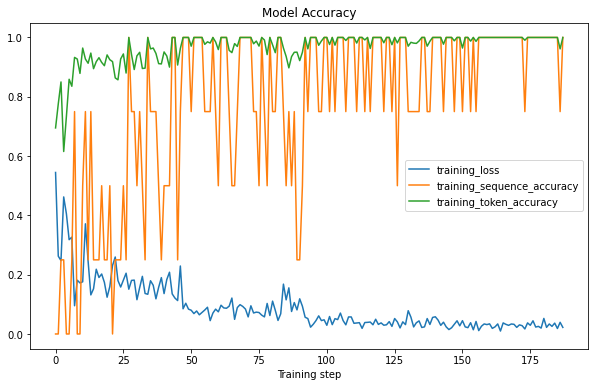

In [806]:
results_figure = results_df.iloc[:,3:].plot(xlabel='Training step', title='Model Accuracy', figsize=(10,6))
print(results_figure)

In [768]:
openai.FineTune(id = '')

openai.api_resources.fine_tune.FineTune

Save the validation results to a CSV with the following line of code in the openAI CLi:

>openai api fine_tunes.results -i ft-IOeMaXvm3EoeJeCTVLFl2URS > 07-Oct-2021_fine-tune_results.csv

In [724]:
# List all fine-tuned models you've created
fine_tunes_list = openai.FineTune.list()
fine_tunes_list.data[-1].fine_tuned_model

'curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29'

In [687]:
# Test the model. Note that the prompt must be formatted the same as the fine-tuning data, specifically with these features: 
# end with the indicator string `\n\n###\n\n` for the model to start generating completions, rather than continuing with the 
# prompt. 

#Load last saved version of the fine-tuning dataset as a dataframe

prompts = pd.read_csv('GPT_causal_extraction_fine-tuning_dataset_v07-10-2021.csv')

# Add a separator at the end of each prompt to signal the end of the dividing point between the prompt and completion
prompts['focused_sentences'] = prompts['focused_sentences'].astype(str) + '\n\n###\n\n'

prompts

,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16
0,causes,31543413,Lateral epicondylitis is the most common caus...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...,"\nLateral epicondylitis, causes, elbow pain\n",NaN
1,causes,31543413,This article reviews the pathophysiological f...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...,NaN,NaN
2,causes,25103301,Data for the causes of maternal deaths are ne...,GLOBAL CAUSES OF MATERNAL DEATH: A WHO SYSTEMA...,NaN,NaN
3,causes,22133988,From the most recent data the magnitude of vi...,GLOBAL ESTIMATES OF VISUAL IMPAIRMENT: 2010. F...,NaN,NaN
4,causes,29032195,Contemporary data for causes of vision impair...,GLOBAL CAUSES OF BLINDNESS AND DISTANCE VISION...,NaN,NaN
...,...,...,...,...,...,...
9638,causes,31605189,Vestibular evoked myogenic potential (VEMP) c...,CLINICAL SIGNIFICANCE OF CERVICAL AND OCULAR V...,NaN,NaN
9639,causes,26526553,Given the role of uncoupling protein 2 (UCP2)...,INTERACTIONS BETWEEN UNCOUPLING PROTEIN 2 GENE...,NaN,NaN
9640,causes,26047942,Hepatitis C virus infection is a worldwide he...,META-ANALYSIS OF THE EFFICACY AND SAFETY OF SO...,NaN,NaN
9641,causes,28489599,Pathogenic variants in the gap junction prote...,ASSOCIATION BETWEEN THE P.V37I VARIANT OF GJB2...,NaN,NaN


In [689]:
# Send requests to the API. Make sure to include `stop=["\n#####"]` so that the generated texts ends at the expected place.
start_time = time.time()
batch_size = 0
new_relationships_list = []

prompts_target_rows = prompts[426:526].copy()

for row in prompts_target_rows.itertuples():
    prompt = row[3]
    response = openai.Completion.create(
        model="curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29",
        prompt=prompt,
        max_tokens = 100
        stop=["\n#####"])
    new_relationships = response.choices[0].text
    new_relationships_list.append(new_relationships)
    batch_size += 1

end_time = time.time()

print("Batch size:",batch_size,'\nTime to complete:',end_time-start_time)

prompts_target_rows["curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29"] = new_relationships_list
prompts_target_rows

Batch size: 100 
Time to complete: 43.55474257469177


,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16,curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29
426,causes,27324830,Because few studies reported clinical outcome...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
427,causes,27324830,Interventions that cause weight loss are effe...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
428,causes,27324830,Similar results were seen in sub-group analys...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
429,causes,29269069,"Although cranioplasty is a common procedure, ...",MASSIVE BRAIN SWELLING AND DEATH AFTER CRANIOP...,NaN,NaN,\ncranioplasty | causes | complications
430,causes,31588651,Enteroviruses are RNA viruses found as commen...,GLOBAL EPIDEMIOLOGY OF NONPOLIO ENTEROVIRUSES ...,NaN,NaN,\nInfectious bronchitis | causes | disease\nI...
...,...,...,...,...,...,...,...
521,causes,29723893,Cancer is the leading cause of death in conte...,CAUSES OF DEATH IN PATIENTS WITH VENOUS THROMB...,NaN,NaN,\n
522,causes,29723893,The authors performed a meta-analysis to anal...,CAUSES OF DEATH IN PATIENTS WITH VENOUS THROMB...,NaN,NaN,\n
523,causes,26784527,Surgical site infection (SSI) is one of the m...,REDUCING SURGICAL SITE INFECTIONS IN ABDOMINAL...,NaN,NaN,\n
524,causes,30909308,Colorectal cancer (CRC) is a major worldwide ...,ADHERENCE TO POST-POLYPECTOMY SURVEILLANCE GUI...,NaN,NaN,\nColorectal cancer (CRC) | causes | cancer-


In [815]:
for choice in response.choices:
    reply=choice.text
reply

' \n'

Results of the first batch of calls to the API:  
Batch size: 141  
Time to complete: 29.010086059570312 seconds  

The openAI account logged transaction as:
>curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16, 141 requests
4986 prompt + 1512 completion = 6498 tokens ($0.19)

Results of the second batch of calls to the API:  
Batch size: 100  
Time to complete: 43.55474257469177  

The openAI account logged transaction as:  
>curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29, 84 requests
>2963 prompt + 920 completion = 3883 tokens ($0.12) 

>curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29, 16 requests
>509 prompt + 168 completion = 677 tokens ($0.02)

In [690]:
# Add the new model-generated relationship statements to the full training set dataframe. 
prompts["curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29"] = prompts_target_rows["curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29"]
prompts[426:526]

,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16,curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29
426,causes,27324830,Because few studies reported clinical outcome...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
427,causes,27324830,Interventions that cause weight loss are effe...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
428,causes,27324830,Similar results were seen in sub-group analys...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
429,causes,29269069,"Although cranioplasty is a common procedure, ...",MASSIVE BRAIN SWELLING AND DEATH AFTER CRANIOP...,NaN,NaN,\ncranioplasty | causes | complications
430,causes,31588651,Enteroviruses are RNA viruses found as commen...,GLOBAL EPIDEMIOLOGY OF NONPOLIO ENTEROVIRUSES ...,NaN,NaN,\nInfectious bronchitis | causes | disease\nI...
...,...,...,...,...,...,...,...
521,causes,29723893,Cancer is the leading cause of death in conte...,CAUSES OF DEATH IN PATIENTS WITH VENOUS THROMB...,NaN,NaN,\n
522,causes,29723893,The authors performed a meta-analysis to anal...,CAUSES OF DEATH IN PATIENTS WITH VENOUS THROMB...,NaN,NaN,\n
523,causes,26784527,Surgical site infection (SSI) is one of the m...,REDUCING SURGICAL SITE INFECTIONS IN ABDOMINAL...,NaN,NaN,\n
524,causes,30909308,Colorectal cancer (CRC) is a major worldwide ...,ADHERENCE TO POST-POLYPECTOMY SURVEILLANCE GUI...,NaN,NaN,\nColorectal cancer (CRC) | causes | cancer-


In [700]:
# Save the results to a CSV
prompts.to_csv('GPT_causal_extraction_fine-tuning_dataset_v07-10-2021.csv', index=False)

#### Extract relationships by hand to check GPT3 accuracy

In [701]:
df = pd.read_csv('GPT_causal_extraction_fine-tuning_dataset_v07-10-2021.csv', encoding='utf-8')

In [698]:
# Initialize row_number wherever you left off
row_number = 425

In [703]:
row_number += 1
print("Row",row_number)

gpt3_generated = df.iloc[row_number,6]
print(gpt3_generated, '\n')

original_text = df.iloc[row_number,].focused_sentences
term_list = text_to_CUIs(original_text)

print(original_text)
# print([x[2] if len(x) == 3 else x[1] for x in term_list])
outlist = []
for word in term_list:
    if len(word) == 3:
        outlist.append('('+word[1]+' '+word[2]+')')
    else:
        outlist.append(word[1])
print('\n',' '.join(outlist))

Row 426
 
 

 Because few studies reported clinical outcomes of CVD, analyses were limited to cardiovascular risk factors (83 studies). 

###



  Because (few C0205388) (studies C0947630) (reported C0700287) (clinical C0205210) (outcomes C0085415) of (CVD C0007222) analyses were (limited C0439801) to (cardiovascular C3887460) (risk factors C0035648) (83 C4517888) (studies C0947630) 


In [651]:
# Add a list of the relationships described in the extracts from the article. Separate fields for each relationship with commas and separate
# relationships with new lines, as follows: subject, verb, object
df.at[row_number,'relationships'] = '''
Coronary heart disease, causes, loss of quality of life
Coronary heart disease, causes, disability
Coronary heart disease, causes, death
'''

timestamp = datetime.now().strftime("%d-%m-%Y")
filename = 'GPT_causal_extraction_fine-tuning_dataset_v{}.csv'.format(timestamp)
df.to_csv(filename, index=False)
print('Saved ',filename)

print("Row",row_number)
print('\n', df.iloc[row_number].relationships)

Saved  GPT_causal_extraction_fine-tuning_dataset_v07-10-2021.csv
Row 423

 
Coronary heart disease, causes, loss of quality of life
Coronary heart disease, causes, disability
Coronary heart disease, causes, death



In [704]:
df.iloc[row_number-2:row_number+3]

,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16,curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29
424,causes,28178135,The durability of cervical disc arthroplastie...,DURABILITY OF CERVICAL DISC ARTHROPLASTIES AND...,NaN,NaN,NaN
425,causes,32127107,"In total, 87 species caused clinically releva...",A GLOBAL UPDATE ON RARE NON-TUBERCULOUS MYCOBA...,NaN,NaN,NaN
426,causes,27324830,Because few studies reported clinical outcome...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
427,causes,27324830,Interventions that cause weight loss are effe...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n
428,causes,27324830,Similar results were seen in sub-group analys...,INTERVENTIONS THAT CAUSE WEIGHT LOSS AND THE I...,NaN,NaN,\n


In [706]:
# Load the dataset that you're annotating
filename = 'GPT_causal_extraction_fine-tuning_dataset_v09-10-2021.csv'
df = pd.read_csv(filename, encoding='utf-8')

# Change the delimiters between subject, predicate, and object from commas to pipes
df['relationships'] = df['relationships'].str.replace(',', ' |')
df['relationships'].head(20)

0       \nLateral epicondylitis | causes | elbow pain\n
1                                                   NaN
2                                                   NaN
3                                                   NaN
4                                                   NaN
5                           \nSepsis | causes | death\n
6     \ninflammatory response | causes | encephalopa...
7                                                   NaN
8                                                   NaN
9     \nEscherichia coli | causes | meningitis\nHaem...
10                                                  NaN
11                                                  NaN
12                                                  NaN
13    \nTraumatic spinal injury (TSI) | causes | mor...
14    \nStenotrophomonas maltophilia | causes | infe...
15                                                  NaN
16                \nmaltophilia | causes | infections\n
17    \nVaricella-zoster virus (VZV) | causes | 

In [707]:
# Write the results back to CSV
df.to_csv(filename, index=False)

In [656]:
# Change the delimiters between subject, predicate, and object from commas to pipes
df['relationships'] = df['relationships'].str.replace(',', ' |')

In [283]:
df.iloc[300,].relationships

'\nDementia | causes | death\n'

So far we've manually annotated all the articles from the "Pubmed_search_30Sept2021-11.32am.txt" file. I've done another Pubmed search as follows:
>((("cause"[Title/Abstract] OR "causes"[Title/Abstract] OR "caused"[Title/Abstract]) NOT "all-cause"[Title/Abstract]) AND ("hasabstract"[All Fields] AND ("meta analysis"[Publication Type] OR "systematic review"[Filter]) AND "humans"[MeSH Terms])) AND ((fha[Filter]) AND (guideline[Filter] OR meta-analysis[Filter] OR randomizedcontrolledtrial[Filter] OR review[Filter] OR systematicreview[Filter]) AND (humans[Filter]) AND (english[Filter]) AND (2015:2021[pdat]))

The search returned 10,439 results sorted by best match, and I saved the PMIDs for top 10,000 of those in the file named: "Pubmed_search_1Oct2021-16.22pm.txt"

In [285]:
# Merge the 10,000 new PMIDs into the fine-tuning dataframe
with open('Pubmed_search_1Oct2021-16.22pm.txt','r') as file:
    raw_list = file.readlines()
print(raw_list[:5])

['31543413\n', '29032195\n', '26709689\n', '33275949\n', '30712879\n']


In [286]:
PMIDs_list = []
for pmid in raw_list:
    pmid = pmid[:-1]
    PMIDs_list.append(pmid)
print(PMIDs_list[:5])

['31543413', '29032195', '26709689', '33275949', '30712879']


In [306]:
len(PMIDs_list)

10000

In [307]:
def causality_search(pmid):
    
    regex_cause = r"([^.\n]*?[^-]caus*[^.]*\.[^0-9])"
    regex_due = r"([^.\n]*?[^-]due to[^.]*\.[^0-9])"
    regex_result = r"([^.\n]*?[^-]result*[^.]*\.[^0-9])"
    
    sentence_list = []
    
    article = soup.find(text=pmid)
    try:
        title = article.findNext('articletitle').get_text()
    except:
        title = ""
    try:
        abstract = article.findNext('abstracttext').get_text()
    except:
        abstract = ""
    if len(title+abstract) == 0:
        pass
    else:
        title_abstract = title.upper()+' '+abstract
        sentence_list+=re.findall(regex_cause, title_abstract)
        sentence_list+=re.findall(regex_due, title_abstract)
        sentence_list+=re.findall(regex_result, title_abstract)
    if type(sentence_list) == None:
        pass
    elif len(sentence_list) == 0:
        pass
    else:
        data = ['causes', pmid, sentence_list, title_abstract]
        return data

In [313]:
batch_size = 200
data = []

for i in range(0,10000, batch_size):
    PMIDs_batch = PMIDs_list[i:i+batch_size]
    
    url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={PMIDs_list}&retmode=xml&rettype=abstract'
    url = url.format(PMIDs_list=PMIDs_batch)
    response = requests.get(url)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    
    for pmid in PMIDs_batch:
        results = causality_search(pmid)
        if results == None:
            pass
        else:
            data.append(results)
    
df = pd.DataFrame(data, columns=['term', 'pmid', 'focused_sentences', 'text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6869 entries, 0 to 6868
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   term               6869 non-null   object
 1   pmid               6869 non-null   object
 2   focused_sentences  6869 non-null   object
 3   text               6869 non-null   object
dtypes: object(4)
memory usage: 214.8+ KB


In [314]:
df = df.explode('focused_sentences', ignore_index=True)
df.head()

,term,pmid,focused_sentences,text
0,causes,31543413,Lateral epicondylitis is the most common caus...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...
1,causes,31543413,This article reviews the pathophysiological f...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...
2,causes,29032195,Contemporary data for causes of vision impair...,GLOBAL CAUSES OF BLINDNESS AND DISTANCE VISION...
3,causes,33275949,Many causes of vision impairment can be preve...,CAUSES OF BLINDNESS AND VISION IMPAIRMENT IN 2...
4,causes,33275949,We estimated the prevalence and relative cont...,CAUSES OF BLINDNESS AND VISION IMPAIRMENT IN 2...


In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   term               9988 non-null   object
 1   pmid               9988 non-null   object
 2   focused_sentences  9988 non-null   object
 3   text               9988 non-null   object
dtypes: object(4)
memory usage: 312.2+ KB


In [316]:
# Drop duplicates where all columns are the same between articles
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9550 entries, 0 to 9987
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   term               9550 non-null   object
 1   pmid               9550 non-null   object
 2   focused_sentences  9550 non-null   object
 3   text               9550 non-null   object
dtypes: object(4)
memory usage: 373.0+ KB


In [317]:
# Drop duplicates where all but the PMID are the same between rows
df.drop_duplicates(subset = ['focused_sentences','text'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9487 entries, 0 to 9987
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   term               9487 non-null   object
 1   pmid               9487 non-null   object
 2   focused_sentences  9487 non-null   object
 3   text               9487 non-null   object
dtypes: object(4)
memory usage: 370.6+ KB


In [370]:
# Get more articles for fine-tuning
original_dataset = pd.read_csv('GPT_extraction_fine-tuning_dataset.csv')

In [371]:
original_dataset.head()

,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16
0,causes,31543413,Lateral epicondylitis is the most common caus...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...,"\nLateral epicondylitis, causes, elbow pain\n",NaN
1,causes,31543413,This article reviews the pathophysiological f...,MANAGEMENT OF LATERAL EPICONDYLITIS. Lateral e...,NaN,NaN
2,causes,25103301,Data for the causes of maternal deaths are ne...,GLOBAL CAUSES OF MATERNAL DEATH: A WHO SYSTEMA...,NaN,NaN
3,causes,22133988,From the most recent data the magnitude of vi...,GLOBAL ESTIMATES OF VISUAL IMPAIRMENT: 2010. F...,NaN,NaN
4,causes,29032195,Contemporary data for causes of vision impair...,GLOBAL CAUSES OF BLINDNESS AND DISTANCE VISION...,NaN,NaN


In [375]:
new_dataset = df.copy()

In [373]:
full_dataset = pd.concat([original_dataset, new_dataset], join='outer', ignore_index=True)
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10157 entries, 0 to 10156
Data columns (total 6 columns):
 #   Column                                                            Non-Null Count  Dtype 
---  ------                                                            --------------  ----- 
 0   term                                                              10157 non-null  object
 1   pmid                                                              10157 non-null  int64 
 2   focused_sentences                                                 10157 non-null  object
 3   text                                                              10157 non-null  object
 4   relationships                                                     325 non-null    object
 5   model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16  280 non-null    object
dtypes: int64(1), object(5)
memory usage: 476.2+ KB


In [443]:
# Drop duplicates where all but the PMID are the same between rows
full_dataset.drop_duplicates(subset = ['focused_sentences','text'], inplace = True, keep='first')
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9643 entries, 0 to 9812
Data columns (total 6 columns):
 #   Column                                                            Non-Null Count  Dtype 
---  ------                                                            --------------  ----- 
 0   term                                                              9643 non-null   object
 1   pmid                                                              9643 non-null   int64 
 2   focused_sentences                                                 9643 non-null   object
 3   text                                                              9643 non-null   object
 4   relationships                                                     152 non-null    object
 5   model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16  136 non-null    object
dtypes: int64(1), object(5)
memory usage: 527.4+ KB


In [825]:
# Save the dataframe to a CSV
full_dataset.to_csv('GPT_extraction_datafile_for_causation.csv', index=False)

In [821]:
datafile = 'Development_FIles/GPT_causal_extraction_fine-tuning_dataset_v09-10-2021.csv'
df = pd.read_csv(datafile, encoding='utf-8')

In [817]:
full_dataset = pd.read_csv('GPT_extraction_datafile_for_causation.csv', encoding = 'utf-8')

In [824]:
full_dataset.iloc[800:820,]

,term,pmid,focused_sentences,text,relationships,model_curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-01-12-16-16,curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-08-02-56-29,curie:ft-user-92vwagyayt5ojmicz5l5vwi1-2021-10-13-18-13-06
800,causes,30240479,Whipple's disease (WD) is known as an infrequ...,WHIPPLE'S DISEASE: CASE REPORT AND REVIEW OF T...,\nTropherima whipplei | causes | Whipple's dis...,NaN,NaN,\n\n###\n\n \nTropherima whipplei | causes | W...
801,causes,30240479,The disease is frequently characterized by a ...,WHIPPLE'S DISEASE: CASE REPORT AND REVIEW OF T...,NaN,NaN,NaN,\n\n###\n\n \n
802,causes,30240479,"Herein, we describe the case a 62-year-old ma...",WHIPPLE'S DISEASE: CASE REPORT AND REVIEW OF T...,NaN,NaN,NaN,\n\n###\n\n \n
803,causes,33543469,It can result from many different causes.,PNEUMOCEPHALUS AS A RARE COMPLICATION: A SYSTE...,NaN,NaN,NaN,\n\n###\n\n \n
804,causes,33543469,The most common cause is head or facial trauma.,PNEUMOCEPHALUS AS A RARE COMPLICATION: A SYSTE...,NaN,NaN,NaN,\n\n###\n\n \n
805,causes,33543469,"Other causes include neoplasms, infections, an...",PNEUMOCEPHALUS AS A RARE COMPLICATION: A SYSTE...,NaN,NaN,NaN,\n\n###\n\n \n
806,causes,33543469,Spontaneous non-traumatic pneumocephalus is a ...,PNEUMOCEPHALUS AS A RARE COMPLICATION: A SYSTE...,\nbone defects | causes | spontaneous non-trau...,NaN,NaN,\n\n###\n\n \nbone defects | causes | spontane...
807,causes,25406023,Gastric cancer is one of the most dreadful ne...,THE ROLE OF HIPEC IN THE TREATMENT OF PERITONE...,\nGastric cancer | causes | death\n,NaN,NaN,\n\n###\n\n \n
808,causes,25406023,Despite being the cause of 60% of deaths from...,THE ROLE OF HIPEC IN THE TREATMENT OF PERITONE...,\ngastric cancer | causes | death\nperitoneal ...,NaN,NaN,\n\n###\n\n \n
809,causes,25406023,We performed a systematic review of the curre...,THE ROLE OF HIPEC IN THE TREATMENT OF PERITONE...,NaN,NaN,NaN,\n\n###\n\n \n


In [406]:
text = '\n\n###\n\n'
print(len(text))
print(len(text[:-7]))

7
0


In [822]:
# Remove formatting from the original dataset that had been added for GPT3 fine-tuning

# Remove the separator at the end of each prompt that signaled the end of the dividing point between the prompt and completion
# df['filename'] = df.apply(lambda x: x['filename'][:-4], axis = 1)
full_dataset.loc[:, 'focused_sentences'] = df.loc[:, 'focused_sentences'].apply(lambda x: x[:-7])

## To Do
- strip off the extra "|" at the end of all the `causes` and `prevents` relationships
- change all the `means` relationships to `synonym_of`
- figure out how to capture likelihood or frequency of a causal relationship
- Group relationships by PMID and send full title+abstract to GPT for extraction
- When the "causes" extraction is working well, create fine-tuning datasets for the "means" (i.e. synonyms), "is a," and "symptom of" relationships

In [835]:
# Fill in conditions for causal relationships whenever they are stated

# Add a column to all of the relationships for conditions
# Load the dataset
datafile = 'GPT_extraction_datafile_for_causation_with_conditions.csv'
df = pd.read_csv(datafile, encoding='utf-8')

In [886]:
df['relationships'] = df['relationships'].fillna('\n\n')

In [891]:
# Reformat the relationships column so that all the relationships in a cell become 
# items in a list
reformatted_relationships = []
for row in df.iterrows():
    try:
        rel_list = row[1].relationships.split('\n')
        new_list = []
        for item in rel_list:
            if len(item) > 0:
                item = item + ' |  |'
                new_list.append(item)
        reformatted_relationships.append(new_list)
    except:
        pass
df.relationships = reformatted_relationships

In [896]:
df.to_csv('GPT_extraction_datafile_for_causation_with_conditions.csv', index=False)

<a id='performance_assessment'></a>
## Performance Assessment

![image](GPT3-CurieAccuracyforExtractingCausalRelationshipsfromMedicalLiterature.png)  
These accuracy figures were taken as the mean of the last 5 accuracy scores from the results files for fine-tuning jobs done with 200, 400, and 800 training examples each. The black marker in the figure represents the 98% accuracy threshold, which this trend line estimates will be reached after 1600 training examples. Validation_token_accuracy is the proportion of tokens accurately predicted in the validation set. Each token represents about 4 characters.  

Note that the theoretical upper limit for accuracy depends upon the quality of the training and validation data. If the annotators follow the same patterns for extraction perfectly, the theoretical maximum accuracy should be close to 100%. Thus, it is important that all annotators adhere the same logical patterns consistent with the desired knowledge architecture.

Basic measures in the confusion matrix are:
- Relationship was/was not stated by the author
- Relationship was/was not extracted correctly

![image](Assess_GPT_accuracy.png)